## Training Models


In [5]:
import os
import glob

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [61]:
# ============================================================
# 1. LOAD TRAIN INPUT FILES
# ============================================================

TRAIN_DIR = "/Users/jakeblumengarten/NFLBDB/train_data"

usecols = [
    "game_id", "play_id", "nfl_id", "frame_id",
    "x", "y", "s", "a", "dir", "o",
    "absolute_yardline_number",
    "player_height", "player_weight",
    "player_position", "play_direction",
    "ball_land_x", "ball_land_y", "player_position", "player_to_predict"
]

input_files = sorted(glob.glob(os.path.join(TRAIN_DIR, "input_2023_w*.csv")))
print("Found input files:", len(input_files))

dfs = []
for f in input_files:
    dfs.append(pd.read_csv(f, usecols=usecols))

df = pd.concat(dfs, ignore_index=True)
print("Tracking shape:", df.shape)

Found input files: 18
Tracking shape: (4880579, 18)


In [26]:
# Load all post-ball (output) files
output_files = sorted(glob.glob(os.path.join(TRAIN_DIR, "output_2023_w*.csv")))
print("Found output files:", len(output_files))

dfs_post = []
for f in output_files:
    dfs_post.append(pd.read_csv(f))
df_post = pd.concat(dfs_post, ignore_index=True)
print("Post-ball tracking shape:", df_post.shape)

Found output files: 18
Post-ball tracking shape: (562936, 6)


In [88]:
# ============================================================
# 2. LOAD & MERGE SUPPLEMENTARY DATA
# ============================================================

SUPP_PATH = "/Users/jakeblumengarten/NFLBDB/data/supplementary_data.csv"

game_data = pd.read_csv(SUPP_PATH)

columns_to_keep = [
    "game_id", "play_id",
    "quarter", "game_clock", "down", "yards_to_go",
    "pass_result", "pass_length",
    "offense_formation", "receiver_alignment",
    "route_of_targeted_receiver",
    "dropback_distance",
    "defenders_in_the_box",
    "team_coverage_type",
    "expected_points_added", "possession_team",
    "defensive_team", "home_team_abbr",
    "visitor_team_abbr"
]

game_data = game_data[columns_to_keep]

df = df.merge(game_data, on=["game_id", "play_id"], how="left")

/var/folders/gk/xhdyjxtj78z4jp7fjw0djvm80000gn/T/ipykernel_94798/716524975.py:7: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  game_data = pd.read_csv(SUPP_PATH)


In [8]:
# ============================================================
# DISTANCE TO BALL LANDING (PLAY-LEVEL, NO LEAKAGE)
# ============================================================

# ball_land_x/y are constant per play; forward-fill for safety
df["ball_land_x"] = df.groupby(["game_id", "play_id"])["ball_land_x"].transform("first")
df["ball_land_y"] = df.groupby(["game_id", "play_id"])["ball_land_y"].transform("first")

df["distance_to_ball"] = np.sqrt(
    (df["ball_land_x"] - df["x"])**2 +
    (df["ball_land_y"] - df["y"])**2
)

In [9]:
# ============================================================
# 3. BUILD LABELS (dx, dy)
# ============================================================

df = df.sort_values(
    ["game_id", "play_id", "nfl_id", "frame_id"]
).reset_index(drop=True)

grp = df.groupby(["game_id", "play_id", "nfl_id"], sort=False)

df["dx"] = grp["x"].shift(-1) - df["x"]
df["dy"] = grp["y"].shift(-1) - df["y"]

df = df.dropna(subset=["dx", "dy"]).reset_index(drop=True)
print("After label creation:", df.shape)

After label creation: (4707429, 33)


In [10]:
# ============================================================
# 4. HEIGHT → INCHES
# ============================================================

def height_to_inches(h):
    if isinstance(h, str) and "-" in h:
        try:
            ft, inch = h.split("-")
            return int(ft) * 12 + int(inch)
        except:
            return np.nan
    return np.nan

df["player_height_inches"] = df["player_height"].apply(height_to_inches)

In [11]:
# ============================================================
# 5. ENCODE CATEGORICAL VARIABLES
# ============================================================

cat_cols = [
    "play_direction",
    "player_position",
    "pass_result",
    "offense_formation",
    "receiver_alignment",
    "route_of_targeted_receiver",
    "team_coverage_type",
]

for col in cat_cols:
    df[col + "_enc"] = (
        df[col]
        .astype("category")
        .cat.codes
        .astype("int32")
    )

# defenders_in_the_box is numeric — do NOT encode
df["defenders_in_the_box"] = df["defenders_in_the_box"].astype("float32")

In [12]:
# ============================================================
# 6. TEMPORAL & MOTION FEATURES
# ============================================================

df["x_prev"] = grp["x"].shift(1)
df["y_prev"] = grp["y"].shift(1)
df["s_prev"] = grp["s"].shift(1)
df["dir_prev"] = grp["dir"].shift(1)
df["o_prev"] = grp["o"].shift(1)

df["vx"] = (df["x"] - df["x_prev"]).fillna(0.0)
df["vy"] = (df["y"] - df["y_prev"]).fillna(0.0)
df["dis_manual"] = np.sqrt(df["vx"]**2 + df["vy"]**2)

df["speed_change"] = (df["s"] - df["s_prev"]).fillna(0.0)
df["dir_change"] = (df["dir"] - df["dir_prev"]).abs().fillna(0.0)
df["orientation_change"] = (df["o"] - df["o_prev"]).abs().fillna(0.0)

max_frame = grp["frame_id"].transform("max")
df["frame_id_norm"] = df["frame_id"] / max_frame

In [13]:
# ============================================================
# 7. GAME CLOCK → SECONDS
# ============================================================

gc = df["game_clock"].fillna("0:00")
df["game_clock_min"] = gc.str.split(":").str[0].astype(float)
df["game_clock_sec"] = gc.str.split(":").str[1].astype(float)
df["game_clock_total_sec"] = (
    df["game_clock_min"] * 60 + df["game_clock_sec"]
)

In [14]:
# ============================================================
# 8. FINAL FEATURE LIST
# ============================================================

FEATURES = [
    "x", "y", "s", "a", "dir", "o",
    "absolute_yardline_number",
    "player_height_inches",
    "player_weight",
    "player_position_enc",
    "play_direction_enc",
    "vx", "vy",
    "dis_manual",
    "speed_change",
    "dir_change",
    "orientation_change",
    "frame_id_norm",
    "quarter",
    "game_clock_total_sec",
    "down",
    "yards_to_go",
    "pass_result_enc",
    "pass_length",
    "offense_formation_enc",
    "receiver_alignment_enc",
    "route_of_targeted_receiver_enc",
    "dropback_distance",
    "defenders_in_the_box",
    "team_coverage_type_enc",
    "expected_points_added",
    "distance_to_ball"
]

df[FEATURES] = df[FEATURES].astype("float32").fillna(0.0)

X = df[FEATURES]
y_dx = df["dx"].astype("float32").values
y_dy = df["dy"].astype("float32").values

print("Final feature matrix:", X.shape)

Final feature matrix: (4707429, 32)


In [15]:
# ============================================================
# 9. TRAIN / VALIDATION SPLIT (CORRECT)
# ============================================================

X_train, X_val, y_dx_train, y_dx_val, y_dy_train, y_dy_val = train_test_split(
    X, y_dx, y_dy, test_size=0.2, random_state=11
)

dtrain_dx = xgb.DMatrix(X_train, label=y_dx_train)
dval_dx   = xgb.DMatrix(X_val, label=y_dx_val)

dtrain_dy = xgb.DMatrix(X_train, label=y_dy_train)
dval_dy   = xgb.DMatrix(X_val, label=y_dy_val)

In [16]:
# ============================================================
# 10. TRAIN XGBOOST MODELS
# ============================================================

params = {
    "objective": "reg:squarederror",
    "eta": 0.1,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "eval_metric": "rmse",
}

num_rounds = 400
early_stopping = 30

print("Training dx model...")
model_dx = xgb.train(
    params,
    dtrain_dx,
    num_boost_round=num_rounds,
    evals=[(dtrain_dx, "train"), (dval_dx, "val")],
    early_stopping_rounds=early_stopping,
    verbose_eval=25,
)

print("Training dy model...")
model_dy = xgb.train(
    params,
    dtrain_dy,
    num_boost_round=num_rounds,
    evals=[(dtrain_dy, "train"), (dval_dy, "val")],
    early_stopping_rounds=early_stopping,
    verbose_eval=25,
)

Training dx model...
[0]	train-rmse:0.27360	val-rmse:0.27377
[25]	train-rmse:0.03877	val-rmse:0.03876
[50]	train-rmse:0.02188	val-rmse:0.02180
[75]	train-rmse:0.01909	val-rmse:0.01901
[100]	train-rmse:0.01790	val-rmse:0.01782
[125]	train-rmse:0.01723	val-rmse:0.01717
[150]	train-rmse:0.01676	val-rmse:0.01674
[175]	train-rmse:0.01644	val-rmse:0.01645
[200]	train-rmse:0.01617	val-rmse:0.01623
[225]	train-rmse:0.01593	val-rmse:0.01602
[250]	train-rmse:0.01571	val-rmse:0.01585
[275]	train-rmse:0.01555	val-rmse:0.01571
[300]	train-rmse:0.01539	val-rmse:0.01560
[325]	train-rmse:0.01526	val-rmse:0.01551
[350]	train-rmse:0.01511	val-rmse:0.01540
[375]	train-rmse:0.01500	val-rmse:0.01532
[399]	train-rmse:0.01489	val-rmse:0.01523
Training dy model...
[0]	train-rmse:0.21126	val-rmse:0.21102
[25]	train-rmse:0.03824	val-rmse:0.03836
[50]	train-rmse:0.02278	val-rmse:0.02284
[75]	train-rmse:0.01960	val-rmse:0.01966
[100]	train-rmse:0.01825	val-rmse:0.01832
[125]	train-rmse:0.01750	val-rmse:0.01758
[1

In [17]:
# ============================================================
# 11. SAVE MODELS
# ============================================================

model_dx.save_model("models/model_dx.json")
model_dy.save_model("models/model_dy.json")

print("Models saved to /models")


Models saved to /models


## Plotting Results


In [95]:
import matplotlib.pyplot as plt
import numpy as np

def plot_play_routes(
    game_id, play_id,
    df, df_post,
    rosters,
    game_data,
    model_dx=None,
    model_dy=None,
    X=None,
    offense_roles=None
):
    if offense_roles is None:
        offense_roles = ["QB", "RB", "WR", "TE", "FB"]

    # Identify targeted receiver(s) for this play
    targeted_mask = (
        (df["game_id"] == game_id) &
        (df["play_id"] == play_id) &
        (df["player_to_predict"] == True)
    )
    targeted_ids = set(df.loc[targeted_mask, "nfl_id"].tolist())

    # Filter all frames for this play (use only columns needed for features and plotting)
    needed_cols = set(X.columns) if X is not None else set()
    needed_cols.update([
        "game_id", "play_id", "nfl_id", "frame_id", "x", "y", "player_position", "jersey_number"
    ])
    # Only keep columns that exist in df
    needed_cols = [col for col in needed_cols if col in df.columns]
    pre = df[(df["game_id"] == game_id) & (df["play_id"] == play_id)][needed_cols].copy()
    post = df_post[(df_post["game_id"] == game_id) & (df_post["play_id"] == play_id)].copy()
    if pre.empty and post.empty:
        print("No data for this play in pre or post files.")
        return

    # Merge roster info for player positions and jersey numbers
    pre = pre.merge(rosters, left_on="nfl_id", right_on="gsis_it_id", how="left")
    post = post.merge(rosters, left_on="nfl_id", right_on="gsis_it_id", how="left")

    # Add predicted next positions for last pre frame if models and X are provided
    if model_dx is not None and model_dy is not None and X is not None and not pre.empty:
        last_pre_frame = pre["frame_id"].max()
        pre_last = pre[pre["frame_id"] == last_pre_frame].copy()
        # Ensure all required columns exist in pre, add missing as 0.0 if needed
        for col in X.columns:
            if col not in pre:
                pre[col] = 0.0
        val_mask = (pre["frame_id"] == last_pre_frame)
        X_play = pre.loc[val_mask, X.columns]
        dx_pred = model_dx.predict(xgb.DMatrix(X_play))
        dy_pred = model_dy.predict(xgb.DMatrix(X_play))
        pre.loc[pre["frame_id"] == last_pre_frame, "x_pred"] = pre_last["x"].values + dx_pred
        pre.loc[pre["frame_id"] == last_pre_frame, "y_pred"] = pre_last["y"].values + dy_pred

    # Combine pre and post for full route (ensure sort by frame_id)
    all_frames = pd.concat([pre, post], ignore_index=True)
    all_frames = all_frames.sort_values(["nfl_id", "frame_id"])

    # --- TEAM INFO: Try to get from game_data, fallback to None ---
    play_context = game_data[(game_data["game_id"] == game_id) & (game_data["play_id"] == play_id)]
    home_team_abbr = visiting_team_abbr = possession_team = defensive_team = None
    if not play_context.empty:
        ctx = play_context.iloc[0]
        # Try to get team names from columns (case-insensitive, support both string and non-string column names)
        ctx_keys = [str(col).lower() for col in ctx.index]
        def get_ctx_val(key):
            return ctx[ctx.index[ctx_keys.index(key)]] if key in ctx_keys else None
        home_team_abbr = get_ctx_val("home_team_abbr")
        visiting_team_abbr = get_ctx_val("visitor_team_abbr")
        possession_team = get_ctx_val("possession_team")
        defensive_team = get_ctx_val("defensive_team")
        # Compose team context string
        team_str = ""
        if home_team_abbr and visiting_team_abbr:
            team_str = f"{visiting_team_abbr} @ {home_team_abbr}"
        if possession_team and defensive_team:
            team_str += f" | Offense: {possession_team}  Defense: {defensive_team}"
        elif possession_team:
            team_str += f" | Offense: {possession_team}"
        elif defensive_team:
            team_str += f" | Defense: {defensive_team}"
        # Add play context
        context_str = team_str
        context_str += (
            f"\nQ{ctx['quarter']}, {ctx['game_clock']}, Down {ctx['down']}, {ctx['yards_to_go']} yds"
        )
        if 'pass_result' in ctx and pd.notnull(ctx['pass_result']):
            context_str += f", Pass: {ctx['pass_result']}"
        if 'offense_formation' in ctx and pd.notnull(ctx['offense_formation']):
            context_str += f", Formation: {ctx['offense_formation']}"
    else:
        context_str = ""

    plt.figure(figsize=(16, 8))
    ax = plt.gca()

    # Draw end zones as light green rectangles
    ax.axvspan(0, 10, color="#b6eab6", alpha=0.5, zorder=0, label="End Zone")
    ax.axvspan(110, 120, color="#b6eab6", alpha=0.5, zorder=0)

    # --- Draw first down marker ---
    # Try to get line of scrimmage and yards_to_go from play context
    los = None
    ytg = None
    play_direction = None
    if not play_context.empty:
        ctx = play_context.iloc[0]
        # Get line of scrimmage (absolute_yardline_number) and yards_to_go
        if "absolute_yardline_number" in df.columns:
            # Use the first frame's LOS for this play
            los_vals = df[(df["game_id"] == game_id) & (df["play_id"] == play_id)]["absolute_yardline_number"]
            if not los_vals.empty:
                los = los_vals.iloc[0]
        if "yards_to_go" in ctx and not pd.isnull(ctx["yards_to_go"]):
            ytg = float(ctx["yards_to_go"])
        # Play direction: "left" or "right"
        if "play_direction" in df.columns:
            pd_vals = df[(df["game_id"] == game_id) & (df["play_id"] == play_id)]["play_direction"]
            if not pd_vals.empty:
                play_direction = pd_vals.iloc[0].lower()
        # Compute first down marker x position
        if los is not None and ytg is not None and play_direction is not None:
            if play_direction == "left":
                first_down_x = los - ytg
            else:
                first_down_x = los + ytg
            # Clamp to field
            first_down_x = max(0, min(120, first_down_x))
            ax.axvline(first_down_x, color="yellow", linestyle="--", linewidth=2, label="First Down Marker", zorder=1)

    # Track which legend labels have been added
    legend_labels = set()
    targeted_color = "#d62728"  # red

    # Plot each player's route (one line per player: from first to last frame)
    for nfl_id, player_df in all_frames.groupby("nfl_id"):
        player_df = player_df.sort_values("frame_id")
        pos = player_df["player_position"].iloc[0] if "player_position" in player_df else ""
        is_offense = pos in offense_roles
        is_targeted = nfl_id in targeted_ids
        if is_targeted:
            color = targeted_color
            route_label = "Targeted Receiver Route"
            pred_label = "Targeted Receiver Predicted Next"
        else:
            color = "royalblue" if is_offense else "orange"
            route_label = "Offense Route" if is_offense else "Defense Route"
            pred_label = "Offense Predicted Next" if is_offense else "Defense Predicted Next"

        # Only add legend label once per group
        plot_label = route_label if route_label not in legend_labels else None

        # Plot a single line from first to last frame for each player
        if len(player_df) >= 2:
            ax.plot([player_df["x"].iloc[0], player_df["x"].iloc[-1]],
                    [player_df["y"].iloc[0], player_df["y"].iloc[-1]],
                    color=color, alpha=0.7, label=plot_label, linewidth=2 if is_targeted else 1.5)
        legend_labels.add(route_label)

        # Mark start and end with jersey number
        if "jersey_number" in player_df and not player_df["jersey_number"].isnull().all():
            start = player_df.iloc[0]
            end = player_df.iloc[-1]
            ax.text(start["x"], start["y"], str(int(start["jersey_number"])), fontsize=8, ha='center', va='center', color='w',
                    bbox=dict(facecolor='black', alpha=0.7, boxstyle='round,pad=0.2'))
            ax.text(end["x"], end["y"], str(int(end["jersey_number"])), fontsize=8, ha='center', va='center', color='k',
                    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

        # Plot predicted next position for last pre frame if available
        if "x_pred" in player_df and "y_pred" in player_df:
            pred_rows = player_df.loc[player_df["x_pred"].notnull() & player_df["y_pred"].notnull()]
            if not pred_rows.empty:
                pred_plot_label = pred_label if pred_label not in legend_labels else None
                ax.scatter(pred_rows["x_pred"], pred_rows["y_pred"], c=color, marker='x', s=120 if is_targeted else 100, label=pred_plot_label, zorder=5)
                legend_labels.add(pred_label)

    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    ax.set_xlabel("X (Yards)")
    ax.set_ylabel("Y (Yards)")
    ax.set_title(f"Player Routes: Game {game_id}, Play {play_id}\n{context_str}")

    # Add caption at the bottom
    plt.figtext(
        0.5, -0.04,
        "Frame shown is the last frame before the ball is thrown (pre-throw). Predicted next positions are model outputs for the next frame.",
        wrap=True, ha="center", va="top", fontsize=11, color="dimgray"
    )

    # Custom legend: ensure End Zone, Offense/Defense/Targeted Route, Offense/Defense/Targeted Predicted Next
    handles, labels = ax.get_legend_handles_labels()
    seen = set()
    handles_labels = [(h, l) for h, l in zip(handles, labels) if not (l in seen or seen.add(l))]
    ax.legend([h for h, l in handles_labels], [l for h, l in handles_labels], loc="upper right")
    ax.grid(True)
    plt.show()

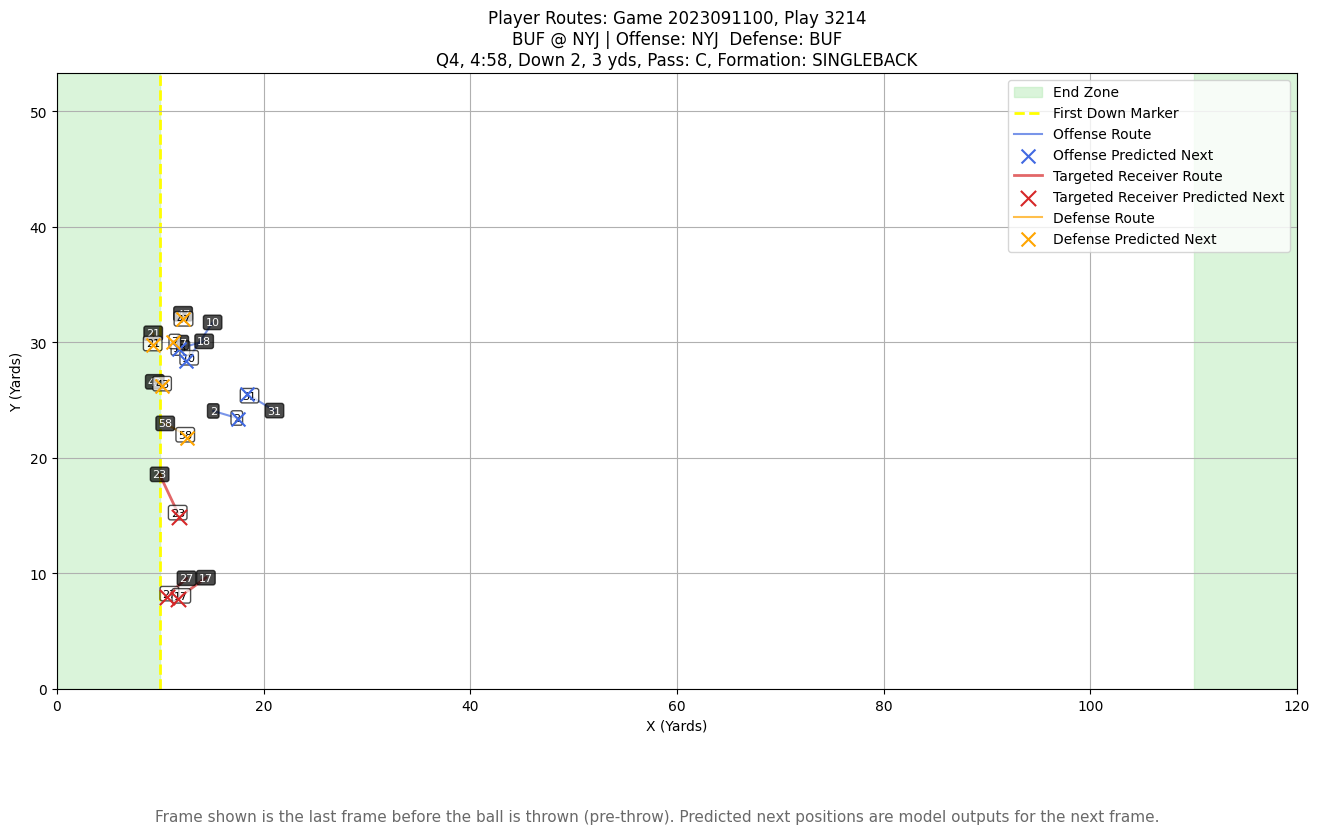

In [99]:
# Update usage to include model_dx, model_dy, and X so predictions are shown
plot_play_routes(
    2023091100, 3214,
    df, df_post,
    rosters,
    game_data,
    model_dx=model_dx,
    model_dy=model_dy,
    X=X
)